<a href="https://colab.research.google.com/github/sehxxnee/AI/blob/main/Korea_Navigation_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Korea Navigation
This module provides functionality to calculate the shortest path between cities in South Korea using the A* algorithm.

It also fetches weather information for the cities and visualizes the route
on an interactive map with Folium.

In [ ]:
import heapq
import math
import folium
import requests
from folium.plugins import AntPath
from IPython.display import display
import logging



# Korea's City coordinates (latitude, longitude)
locations = {
    'Seoul': (37.5665, 126.9780),
    'Suwon': (37.2636, 127.0286),
    'Incheon': (37.4563, 126.7052),
    'Seongnam': (37.4447, 127.1389),
    'Daejeon': (36.3504, 127.3845),
    'Chuncheon': (37.8813, 127.7298),
    'Cheongju': (36.6424, 127.4890),
    'Jeonju': (35.8242, 127.1480),
    'Busan': (35.1796, 129.0756),
    'Daegu': (35.8722, 128.6014),
    'Gwangju': (35.1595, 126.8526),
    'Ulsan': (35.5384, 129.3114),
    'Pohang': (36.0190, 129.3435),
    'Andong': (36.5684, 128.7294),
    'Gimhae': (35.2286, 128.8891)
}

# A* search algorithm with heuristic optimization
def find_optimal_route(locations, start, goal):
    def get_neighbors(city, max_distance=200):
        return [neighbor for neighbor in locations
                if neighbor != city and haversine(locations[city], locations[neighbor]) <= max_distance]
    heuristics = calculate_heuristics(goal, locations)
    queue = [(0 + heuristics[start], 0, start, [start])]
    visited = set()
    while queue:
        _, cost, current_city, path = heapq.heappop(queue)
        if current_city == goal:
            return path, cost
        if current_city in visited:
            continue
        visited.add(current_city)
        for neighbor in get_neighbors(current_city):
            if neighbor not in visited:
                new_cost = cost + haversine(locations[current_city], locations[neighbor])
                priority = new_cost + heuristics[neighbor]
                heapq.heappush(queue, (priority, new_cost, neighbor, path + [neighbor]))
    return None, float('inf')

# Calculate heuristic distances (straight-line distance to the goal)
def calculate_heuristics(goal, locations, cache={}):
    if goal in cache:
        return cache[goal]

    heuristics = {}
    for city in locations:
        heuristics[city] = haversine(locations[city], locations[goal])
    cache[goal] = heuristics
    return heuristics

# Additional feature : Haversine formula to calculate distance between two coordinates
def haversine(coord1, coord2):
    radius = 6371
    lat1, lon1 = coord1
    lat2, lon2 = coord2

    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi / 2) ** 2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    return radius * c

# Additional feature : Fetch current weather data from wttr.in
def get_weather(city):
    url = f"http://wttr.in/{city}?format=3"
    try:
        response = requests.get(url)
        response.raise_for_status()
        return response.text.strip()
    except requests.exceptions.HTTPError as http_err:
        logging.error(f"HTTP error occurred: {http_err}")
    except Exception as e:
        logging.error(f"An error occurred: {e}")
    return f"Could not retrieve weather data for {city}"

# Additional feature : Calculate estimated travel time (average speed: 80 km/h)
def calculate_travel_time(distance, speed=80):
    time = distance / speed
    hours = int(time)
    minutes = int((time * 60) % 60)
    return hours, minutes

# Additional feature : Visualize the route using Folium with animations and markers
def visualize_route(locations, path):
    map_center = locations.get('Daejeon', (36.3504, 127.3845))
    m = folium.Map(location=map_center, zoom_start=7, width='600px', height='600px')

    route = [(locations[city][0], locations[city][1]) for city in path]
    AntPath(locations=route, color="blue", weight=5).add_to(m)
    total_distance = 0
    total_hours = 0
    total_minutes = 0
    for i in range(len(path) - 1):
        city1, city2 = path[i], path[i+1]
        distance = haversine(locations[city1], locations[city2])
        total_distance += distance

        hours, minutes = calculate_travel_time(distance)
        total_hours += hours
        total_minutes += minutes
        weather_info = get_weather(city1)

        folium.Marker(
            location=locations[city1],
            popup=f"{weather_info}",
            icon=folium.Icon(color="green", icon="info-sign")
        ).add_to(m)

    weather_info = get_weather(path[-1])
    folium.Marker(
        location=locations[path[-1]],
        popup=weather_info,
        icon=folium.Icon(color="red", icon="flag")
    ).add_to(m)

    total_hours += total_minutes // 60
    total_minutes = total_minutes % 60

    print(f"Total travel time: {total_hours}h {total_minutes}m")
    return m

# function to get user input
def get_user_input():
    print("<Korea Navigation System>\n")
    print("Available cities:")
    city_list = list(locations.keys())
    for i, city in enumerate(city_list, start=1):
        print(f"{i}. {city}")
    try:
        start_city = city_list[int(input("Enter the number for the start city: ")) - 1]
        goal_city = city_list[int(input("Enter the number for the destination city: ")) - 1]
    except (ValueError, IndexError):
        print("Invalid input. Please enter a valid number.")
        return None, None

    return start_city, goal_city

# Main program
if __name__ == "__main__":
    start_city, goal_city = get_user_input()
    if start_city and goal_city:
        path, shortest_distance = find_optimal_route(locations, start_city, goal_city)
        print(f"The shortest path from {start_city} to {goal_city} is: {path}")
        print(f"The total distance is: {shortest_distance:.2f} km")
        map_result = visualize_route(locations, path)
        display(map_result)

    else:
        print("Could not find the route. Please try again.")

<Korea Navigation System>

Available cities:
1. Seoul
2. Suwon
3. Incheon
4. Seongnam
5. Daejeon
6. Chuncheon
7. Cheongju
8. Jeonju
9. Busan
10. Daegu
11. Gwangju
12. Ulsan
13. Pohang
14. Andong
15. Gimhae
Enter the number for the start city: 2
Enter the number for the destination city: 8
The shortest path from Suwon to Jeonju is: ['Suwon', 'Jeonju']
The total distance is: 160.41 km
Total travel time: 2h 0m


### Example 1) If Seoul and Busan are entered.

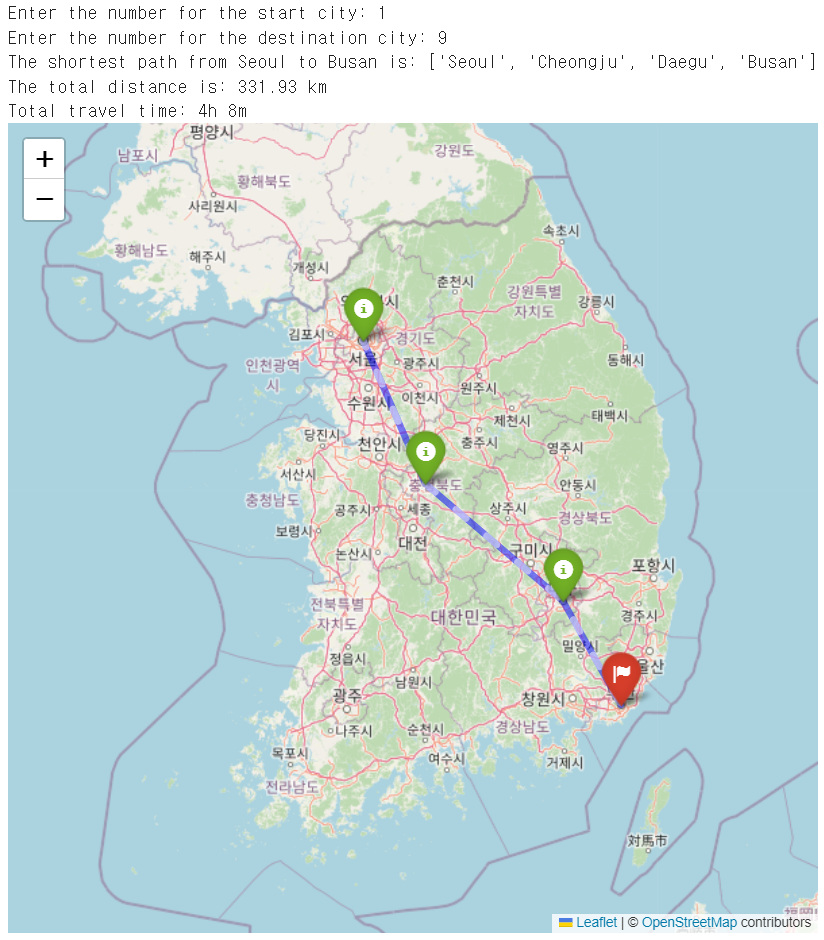

### Example 2) If Suwon and Jeonju are entered.

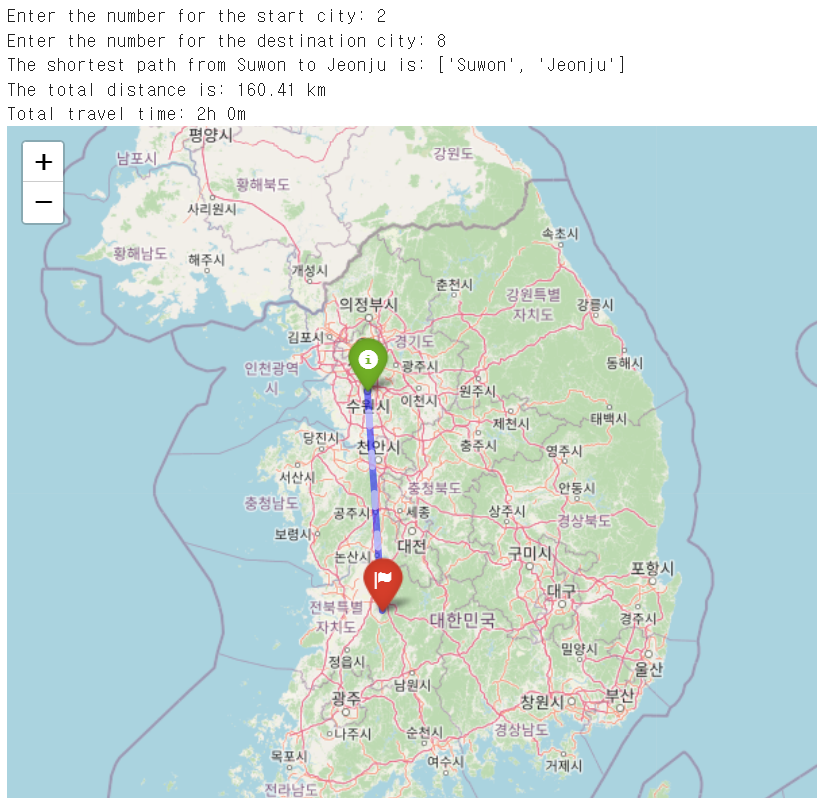

###When a marker is clicked,the weather for that location can be displayed.

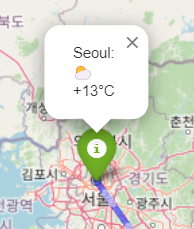

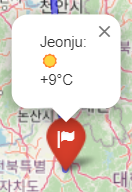